## Notebook Overview  

This notebook walks through a complete **battery-storage arbitrage study** using the custom Python package **`batteryopt`**. 

1. **Solve the optimisation model** : `batteryopt` is initialised with one-day price curve and battery parameters, then executed to determine the profit-maximising charge/discharge schedule.

2. **Capture results in a tidy DataFrame** : The solver’s output—hourly power, state-of-charge (SOC), and cash flows—is collected in `opt_solved`, giving us a single table for analysis and plotting.

3. **Classify battery activity** : Each hour is tagged as **charge (+1)**, **discharge (-1)**, or **idle (0)** so we can colour-code the operating pattern.

4. **Visualise operating strategy vs. market signals**: A dual-axis plot shows battery **state†** and **SOC** against the hourly **price** curve, making it easy to see how the optimiser reacts to price spikes and troughs.

5. **Track daily financial performance**: A cumulative-revenue plot reveals how much money the strategy has earned from midnight up to any intraday time-stamp, highlighting the contribution of each cycle.

> † *Charge = blue, Discharge = red, Idle = black in subsequent figures.*

Together these steps turn raw optimisation output into an intuitive story: **how the battery moves energy, why it does so at those times, and what total revenue is achieved by day’s end.**


In [ ]:
from pyomo.environ import value
import matplotlib.pyplot as plt
import optimizer_run
import numpy as np
import pandas as pd

In [ ]:
solved_model, results = optimizer_run.main()

In [3]:
def define_battery_state(ch_state, disch_state):
    '''returns 1, 0, -1 for charging, idle, and discharging periods'''
    battery_state = None
    if(ch_state==1):
        battery_state = 1
    elif(disch_state==1):
        battery_state = -1
    else:
        battery_state = 0
    return battery_state

In [4]:
opt_solved = pd.DataFrame({'ch_state': [value(solved_model.ch_state[t]) for t in solved_model.T],
                          'disch_state': [value(solved_model.disch_state[t]) for t in solved_model.T],
                          'charge_energy': [value(solved_model.charge_energy[t]) for t in solved_model.T],
                          'discharge_energy': [value(solved_model.discharge_energy[t]) for t in solved_model.T],
                            'soc': [value(solved_model.soc[t]) for t in solved_model.T],
                            'price': [value(solved_model.charge_price[t]) for t in solved_model.T]},
                          index = solved_model.T)
opt_solved['soc'] = opt_solved['soc']*100/value(solved_model.storage_capacity)
opt_solved['revenue'] = opt_solved['price']*(opt_solved['disch_state']*opt_solved['discharge_energy']
                                             -opt_solved['ch_state']*opt_solved['charge_energy'])
opt_solved.loc[:, 'battery_state'] = opt_solved.apply(lambda x: define_battery_state(x['ch_state'], x['disch_state']), axis =1)
opt_solved.loc[25, :] = None

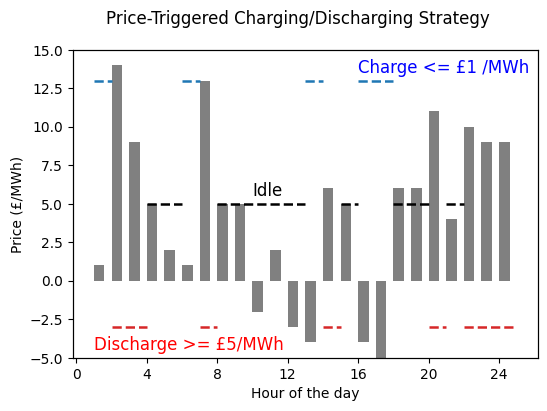

In [5]:
opt_solved['revenue'] = opt_solved['price']*(-opt_solved['charge_energy'] + opt_solved['discharge_energy'])
opt_solved['revenue'].sum()
fig, ax_right = plt.subplots(1, 1, figsize = (6,4))
ax_left = ax_right.twinx()
fig.suptitle('Price-Triggered Charging/Discharging Strategy');
# On the left-axis
ax_right.bar(opt_solved.index, opt_solved['price'], color = 'grey', align = 'edge', width = 0.6);
ax_right.set_ylim([-5, 15]);
ax_right.set_ylabel('Price (£/MWh)');
ax_right.set_xlabel('Hour of the day');

x      = opt_solved.index.to_numpy()           # e.g. [0, 1, 2, … 23]
state  = opt_solved["battery_state"].to_numpy()
dx         = np.diff(x).mean()                 # typical bin width (1 hour)
x_edge     = np.append(x, x[-1] + dx)          # len = N+1
state_edge = np.append(state, state[-1])       # len = N+1
colour_map = {1: "tab:blue", 0: "black", -1: "tab:red"}

for s, c in colour_map.items():
    y_masked = np.where(state_edge == s, state_edge, np.nan)
    ax_left.step(x_edge, y_masked, where="post", color=c, linestyle="--", linewidth=1.8)

ax_right.text(10,5.5,'Idle', fontsize = 12)
ax_right.text(16, 13.5,'Charge <= £1 /MWh', fontsize = 12, color = 'blue')
ax_right.text(1, -4.5,'Discharge >= £5/MWh', fontsize = 12, color = 'red')

ax_right.set_xticks(np.arange(0, 25, 4));
# ax2.step(opt_solved.index, opt_solved['battery_state'], color = 'black', linestyle = '--', where = 'post');
ax_left.set_ylim([-1.25, 1.25]);
ax_left.set_yticks([]);

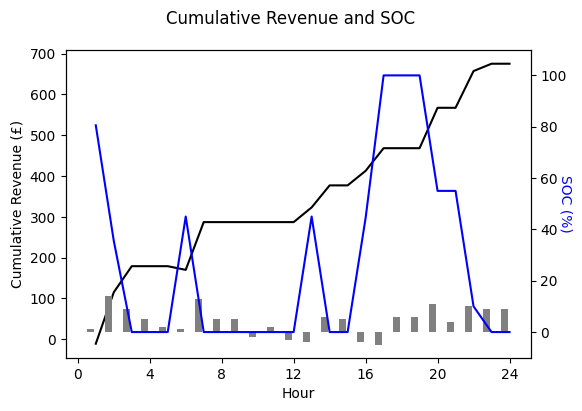

In [7]:

fig, ax_left = plt.subplots(1, 1, figsize = (6,4))
ax_right = ax_left.twinx()

ax_left.plot(opt_solved['revenue'].cumsum(), color = 'black')
ax_left.set_ylabel('Cumulative Revenue (£)', fontsize = 10)
ax_left.set_xlabel('Hour');

ax_right.set_xticks(np.arange(0, 26, 4));
ax_right.bar(opt_solved.index-0.5, opt_solved['price'], color = 'grey', align = 'edge', width = 0.4);
ax_right.plot(opt_solved['soc'], color = 'blue');
ax_right.set_ylim([-10, 110]);
ax_right.set_ylabel('SOC (%)', rotation = -90, color = 'blue');

fig.suptitle('Cumulative Revenue and SOC');